In [46]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

import seaborn as sns
sns.set_style('whitegrid')


In [47]:
# ----------------------- Data loading and preprocessig ---------------------- #

file_train = 'ZipDigits.train'
file_test = 'ZipDigits.test'


def read_data(file_name):
    digits = []
    images = []
    with open(file_name, 'r') as f:
        for line in f:
            line = line.strip().split(' ')
            line = [float(i) for i in line]
            digit = int(line[0])
            data = line[1:]
            images.append(data)
            digits.append(digit)
    return np.array(images), np.array(digits)


def get_features(file_name):
    images, digits = read_data(file_name)
    images = images.reshape(-1, 16, 16)
    images = (images + 1) / 2  # normalize between [0,1]

    index = (digits == 1) | (digits == 5)
    images = images[index]
    digits = digits[index]

    # Extract feature
    intensities = images.reshape(-1, 16 * 16).mean(axis=-1)
    symmetry = np.power(images[..., ::-1] - images,
                        2).reshape(images.shape[0], -1).mean(axis=-1)

    ind_1 = (digits == 1)
    ind_5 = (digits == 5)
    labels = np.zeros(digits.shape[0])
    labels[ind_1] = 1
    labels[ind_5] = -1
    features = np.concatenate((intensities[:, None], symmetry[:, None]),
                              axis=1)
    return features, labels


# ------------------------------ train features ------------------------------ #
features_train, labels_train = get_features(file_train)

# ------------------------------- test features ------------------------------ #
features_test, labels_test = get_features(file_test)

# ----------------------------- combine the data ----------------------------- #
features = np.concatenate((features_train, features_test), axis=0)
labels = np.concatenate((labels_train, labels_test), axis=0)

# ---------------------------- normalize features ---------------------------- #
import sklearn.preprocessing as preprocessing

features = preprocessing.MinMaxScaler(
    feature_range=(-1, 1)).fit_transform(features)

 # --------------------------- split test and train --------------------------- #
from sklearn.model_selection import train_test_split

features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, train_size=300, random_state=78)

In [48]:
# Voronoi clustering
from numpy import unravel_index
from scipy.spatial import distance


def dist_from_set(X, centers):
    dist = distance.cdist(centers, X)  # (p, N)
    dist_min = dist.min(axis=0)  # (N,)
    _ind = dist_min.argmax()
    return dist_min.max(), _ind


def get_clusters(X, num_partition=10):
    centers = np.random.rand(num_partition, X.shape[-1])  # (p, 2)
    center = X[np.random.choice(X.shape[0])]
    centers[:] = center

    for i in range(1, num_partition):
        # calculate the distance from each point to the center
        dist_set, _ind = dist_from_set(X, centers)
        center = X[_ind]
        centers[i] = center

    # Voronoi cluster
    dist = distance.cdist(centers, X)  # (p, N)
    nearest_ind = dist.argmin(axis=0)  # (N,)

    # Clusters = []

    for i in range(num_partition):
        centers[i] = X[nearest_ind == i].mean(axis=0)
    return centers

In [49]:
# RBF-kernel Network Model
from sklearn.linear_model import LogisticRegression

class RBFNet:
    def __init__(self, X, Y, k=4) -> None:
        self.X = X
        self.Y = Y

        # number of bumps
        self.k = k
        self.r = 2 / np.sqrt(k)

        # find cluster center
        self.x_mu = get_clusters(X, self.k)

        # find parametrs
        self.fit()

    def fit(self):
        # compute feature matrics Z: N x (k+1)
        # self.X: N x 2
        # self.x_mu: k x 2
        Z = self.compute_psi(self.X, self.x_mu)

        # compute weights
        self.lin_clf = LogisticRegression(random_state=42).fit(Z, self.Y)
        return self

    def compute_psi(self, X, u):
        # X: N x 2: N x 1 x 2
        # u: k x 2: 1 x k x 2
        # Z: N x k
        Z = self.rbf(np.linalg.norm(X[:, None] - u[None], axis=-1) / self.r)
        return Z

    def rbf(self, z):
        return np.exp(-0.5 * z**2)

    def predict(self, x):
        preds = self.lin_clf.predict(
            self.compute_psi(x, self.x_mu)
        )
        return preds


In [50]:
dict_info = {}
for k in tqdm(range(1, 50)):
    e_cv = []
    for i in range(len(features_train)):
        X_train, y_train = np.delete(features_train, i,
                                     axis=0), np.delete(labels_train, i)
        X_val, y_val = features_train[[i]], labels_train[[i]]
        knnClf = RBFNet(X_train, y_train, k=k)
        pred = knnClf.predict(X_val)
        acc_score = np.mean(pred == y_val)
        e_cv.append(1 - acc_score)
    avg_e_cv = np.mean(e_cv)
    dict_info[k] = avg_e_cv

ind_opt = np.argmin(list(dict_info.values()))
opt_k = list(dict_info.keys())[ind_opt]
print('optimum error: ', dict_info[opt_k])
print('optimal k:', opt_k)


100%|██████████| 49/49 [02:59<00:00,  3.65s/it]

optimum error:  0.03333333333333333
optimal k: 6


In [51]:
knnClf = RBFNet(features_train, labels_train, k=opt_k)
pred_train = knnClf.predict(features_train)
acc_score = np.mean(pred_train == labels_train)
E_in = 1 - acc_score
print('E_in:', E_in)

E_in: 0.033333333333333326


Text(0, 0.5, 'E_cv')

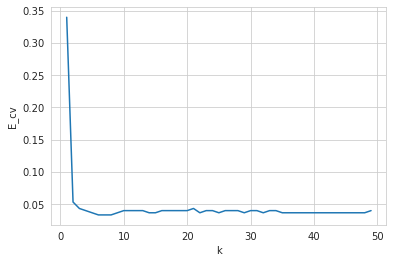

In [52]:
plt.plot(list(dict_info.keys()), list(dict_info.values()))
plt.xlabel('k')
plt.ylabel('E_cv')

In [53]:
knnClf = RBFNet(features_train, labels_train, k=opt_k)

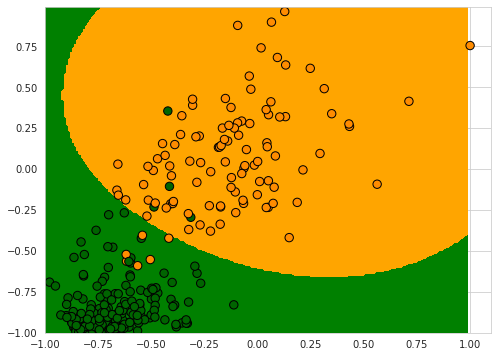

In [54]:
from matplotlib.colors import ListedColormap

cmap_light = ListedColormap(["orange", "green"])
cmap_dark = ListedColormap(["darkorange", "darkgreen"])

xx, yy = np.meshgrid(np.arange(-1, 1, 0.01), np.arange(-1, 1, 0.01))
Z = knnClf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=cmap_light)
plt.scatter(features_train[:, 0], features_train[:, 1], c=labels_train, s=70, cmap=cmap_dark, edgecolors="black")


# (c)

What is the test error E_test?

In [55]:
pred_test = knnClf.predict(features_test)
acc_score = np.mean(pred_test == labels_test)
E_test = 1 - acc_score
print('E_test:', E_test)

E_test: 0.03264094955489616
